In [1]:
import logging
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import pykeen
from pykeen.kge_models import ConvE
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
%matplotlib inline

In [3]:
logging.basicConfig(level=logging.INFO)
logging.getLogger('pykeen').setLevel(logging.INFO)

print(sys.version)

In [4]:
print(time.asctime())

Mon May  6 17:31:51 2019


In [5]:
print(pykeen.get_version())

0.0.26-dev


Check which hyper-parameters are required by ConvE:

In [6]:
ConvE.hyper_params

['embedding_dim',
 'ConvE_input_channels',
 'ConvE_output_channels',
 'ConvE_height',
 'ConvE_width',
 'ConvE_kernel_height',
 'ConvE_kernel_width',
 'conv_e_input_dropout',
 'conv_e_feature_map_dropout',
 'conv_e_output_dropout',
 'margin_loss',
 'learning_rate']

Define output directory:

In [7]:
output_directory = os.path.join(
    os.path.expanduser('~'), 
    'Desktop', 
    'pykeen_test'
)

Define hyper-parameters:

Note: ConvE_height * ConvE_width == embedding_dim

Note: ConvE_kernel_height <= ConvE_height

Note: ConvE_kernel_width <= ConvE_width

Train ConvE:

In [8]:
# Load data
from pykeen.utilities.pipeline import prepare_data
triples, entity_label_to_id, relation_label_to_id, all_entities, num_entities, num_relations = prepare_data('../../tests/resources/data/rdf.nt')

In [9]:
# For the new model
config = dict(
    random_seed                 = 0,
    embedding_dim               = 200,
    ConvE_input_channels        = 1,  
    ConvE_output_channels       = 32,  
    ConvE_height                = 10,
    ConvE_width                 = 20,
    ConvE_kernel_height         = 3,
    ConvE_kernel_width          = 3,
    conv_e_input_dropout        = 0.0,
    conv_e_feature_map_dropout  = 0.0,
    conv_e_output_dropout       = 0.0,
    margin_loss                 = 1,
    preferred_device            = 'gpu',
    num_entities = num_entities,
    num_relations = num_relations
)

In [10]:
model = ConvE(**config)

In [11]:
fit_config=dict(
    learning_rate               = 0.001,
    num_epochs                  = 20,  
    batch_size                  = 128,
)

In [12]:
losses = model.fit(all_entities, triples, **fit_config)

INFO:pykeen.kge_models.base:****Run Model On CUDA****
Training epoch: 100%|██████████| 20/20 [00:00<00:00, 97.08it/s]
INFO:pykeen.kge_models.base:Training took 0 seconds 



Access trained model:

In [13]:
model

ConvE(
  (criterion): MarginRankingLoss()
  (entity_embeddings): Embedding(89, 200)
  (relation_embeddings): Embedding(24, 200)
  (inp_drop): Dropout(p=0.0)
  (hidden_drop): Dropout(p=0.0)
  (feature_map_drop): Dropout2d(p=0.0)
  (loss): BCELoss()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=10368, out_features=200, bias=True)
)

Visualize loss values:

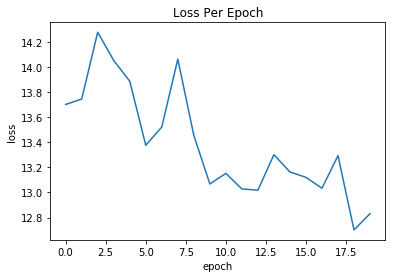

In [14]:
epochs = np.arange(len(losses))
plt.title(r'Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, losses)
plt.show()

Move model to cpu

In [15]:
model._to_cpu()

Load test triples

In [16]:
test_triples, _, _, _, _, _ = prepare_data('../../tests/resources/data/rdf.nt')

Calculate results

In [17]:
from pykeen.utilities.evaluation_utils.metrics_computations import compute_metric_results

In [18]:
results = compute_metric_results(all_entities=all_entities, kg_embedding_model=model, mapped_train_triples=triples, 
                                mapped_test_triples=test_triples, device = model.device, filter_neg_triples=False)

⚽️ corrupting triples: 100%|██████████| 106/106 [00:05<00:00, 21.16it/s]
INFO:pykeen.utilities.evaluation_utils.metrics_computations:Evaluation took 5.02s seconds


In [19]:
results

MetricResults(mean_rank=19.971698113207548, hits_at_k={1: 0.5, 3: 0.5047169811320755, 5: 0.5047169811320755, 10: 0.5141509433962265})